In [1]:
import pandas as pd
from glob import glob
import os
from shutil import copyfile
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18,resnet34
from torchvision.models.inception import inception_v3
from torchvision.models import densenet121
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from pathlib import Path

%matplotlib inline


In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Utility functions

In [4]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)


In [5]:
class FeaturesDataset(Dataset):
    
    def __init__(self,featlst,labellst):
        self.featlst = featlst
        self.labellst = labellst
        
    def __getitem__(self,index):
        return (self.featlst[index],self.labellst[index])
    
    def __len__(self):
        return len(self.labellst)

In [6]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = float(running_loss/len(data_loader.dataset))
    accuracy = float(100. * running_correct/len(data_loader.dataset))
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

## Creating PyTorch datasets

In [7]:
data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [8]:
# For Dogs & Cats dataset
path = Path('../ml_data/dogs_cats/data/')
train_dset = ImageFolder(path/'dogscats/train/',transform=data_transform)
val_dset = ImageFolder(path/'dogscats/valid/',transform=data_transform)
classes=2

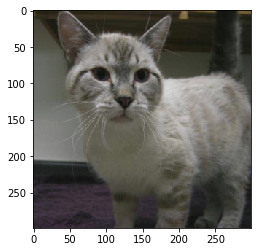

In [10]:
imshow(train_dset[200][0])

## Creating data loader for training and validation datasets

In [11]:
train_loader = DataLoader(train_dset,batch_size=32,shuffle=False,num_workers=3)
val_loader = DataLoader(val_dset,batch_size=32,shuffle=False,num_workers=3)

## Creating Densenet 121 model

In [13]:
my_densenet = densenet121(pretrained=True).features
if is_cuda:
    my_densenet = my_densenet.to(device)

for p in my_densenet.parameters():
    p.requires_grad = False

## Extracting Convolutional features

In [14]:
#For training data
trn_labels = []
trn_features = []

#code to store densenet features for train dataset.
for d,la in train_loader:
    o = my_densenet(Variable(d.to(device)))
    o = o.view(o.size(0),-1)
    trn_labels.extend(la)
    trn_features.extend(o.cpu().data)

#For validation data
val_labels = []
val_features = []

#Code to store densenet features for validation dataset. 
for d,la in val_loader:
    o = my_densenet(Variable(d.to(device)))
    o = o.view(o.size(0),-1)
    val_labels.extend(la)
    val_features.extend(o.cpu().data)

## Creating train and validation feature dataset

In [15]:
# Create dataset for train and validation convolution features
trn_feat_dset = FeaturesDataset(trn_features,trn_labels)
val_feat_dset = FeaturesDataset(val_features,val_labels)

# Create data loaders for batching the train and validation datasets
trn_feat_loader = DataLoader(trn_feat_dset,batch_size=64,shuffle=True,drop_last=True)
val_feat_loader = DataLoader(val_feat_dset,batch_size=64)

## A Fully connected network

In [16]:
class FullyConnectedModel(nn.Module):
    
    def __init__(self,in_size,out_size):
        super().__init__()
        self.fc = nn.Linear(in_size,out_size)

    def forward(self,inp):
        out = self.fc(inp)
        return out

In [17]:
trn_features[0].size(0)

82944

In [18]:
fc_in_size = trn_features[0].size(0)

In [19]:
fc = FullyConnectedModel(fc_in_size,classes)
if is_cuda:
    fc = fc.to(device)

In [20]:
optimizer = optim.Adam(fc.parameters(),lr=0.0001)

## Train and validate the model

In [21]:

train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/home/walle/miniconda3/envs/pytorch1_py37/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 0.057 and training accuracy is 22509/23000      97.0
validation loss is 0.039 and validation accuracy is 1977/2000      98.0
training loss is 0.0052 and training accuracy is 22955/23000      99.0
validation loss is  0.03 and validation accuracy is 1979/2000      98.0
training loss is 0.0012 and training accuracy is 22976/23000      99.0
validation loss is 0.033 and validation accuracy is 1980/2000      99.0
training loss is 0.00062 and training accuracy is 22976/23000      99.0
validation loss is 0.034 and validation accuracy is 1980/2000      99.0
training loss is 0.00043 and training accuracy is 22976/23000      99.0
validation loss is 0.034 and validation accuracy is 1979/2000      98.0
training loss is 0.00032 and training accuracy is 22976/23000      99.0
validation loss is 0.034 and validation accuracy is 1979/2000      98.0
training loss is 0.00025 and training accuracy is 22976/23000      99.0
validation loss is 0.035 and validation accuracy is 1979/2000      9

In [22]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.00013 and training accuracy is 22976/23000      99.0
validation loss is 0.036 and validation accuracy is 1980/2000      99.0
training loss is 0.00011 and training accuracy is 22976/23000      99.0
validation loss is 0.037 and validation accuracy is 1980/2000      99.0
training loss is 9e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.037 and validation accuracy is 1981/2000      99.0
training loss is 7.5e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.037 and validation accuracy is 1983/2000      99.0
training loss is 6.2e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.038 and validation accuracy is 1983/2000      99.0
training loss is 5.2e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.038 and validation accuracy is 1984/2000      99.0
training loss is 4.3e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.039 and validation accuracy is 1984/2000     

In [23]:
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,fc,trn_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,fc,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 2.5e-05 and training accuracy is 22976/23000      99.0
validation loss is  0.04 and validation accuracy is 1984/2000      99.0
training loss is 2.1e-05 and training accuracy is 22976/23000      99.0
validation loss is  0.04 and validation accuracy is 1984/2000      99.0
training loss is 1.8e-05 and training accuracy is 22976/23000      99.0
validation loss is  0.04 and validation accuracy is 1984/2000      99.0
training loss is 1.5e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.041 and validation accuracy is 1984/2000      99.0
training loss is 1.2e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.042 and validation accuracy is 1984/2000      99.0
training loss is 1e-05 and training accuracy is 22976/23000      99.0
validation loss is 0.042 and validation accuracy is 1984/2000      99.0
training loss is 8.7e-06 and training accuracy is 22976/23000      99.0
validation loss is 0.043 and validation accuracy is 1984/2000     

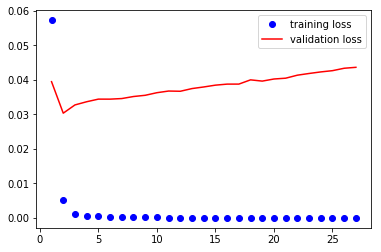

In [24]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()